In [1]:
import spikeinterface.full as si

In [2]:
import probeinterface
from pathlib import Path

base_dir = Path('groundtruth')

probe = probeinterface.read_prb(base_dir / 'mea_256.prb')
from pathlib import Path
from spikeinterface.sortingcomponents.peak_detection import detect_peaks



In [3]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [4]:
def plot_juxta_amplitude(juxta_filename, peaks):
    juxta_sig = np.memmap(juxta_filename, dtype='float32')
    
    med = np.median(juxta_sig)
    mad = np.median(np.abs(juxta_sig-med))*1.4826
    thresh = med + 8*mad
    
    fig, axs = plt.subplots(nrows=2)

    count, bins = np.histogram(peaks['amplitude'], bins=np.arange(np.min(peaks['amplitude']), 0,  0.5))
    ax = axs[0]
    ax.plot(bins[:-1], count)
    ax.axvline(-thresh, color='r', ls='--')
    ax.axvline(med, color='k', ls='-')
    for i in range(1,6):
        ax.axvspan(med - i * mad, med + i * mad, color='k', alpha=0.05)
    
    fig.suptitle('juxta peak amplitude')
    
    ax = axs[1]
    ax.plot(peaks['sample_index'], peaks['amplitude'], ls='None', marker='o')
    ax.axhline(-thresh, color='r', ls='--')
    for i in range(1,6):
        ax.axhspan(med - i * mad, med + i * mad, color='k', alpha=0.05)

/media/cure/Secondary/pierre/softwares/spikeinterface/src/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/202 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/300 [00:00<?, ?it/s]

detect peaks using by_channel:   0%|          | 0/180 [00:00<?, ?it/s]

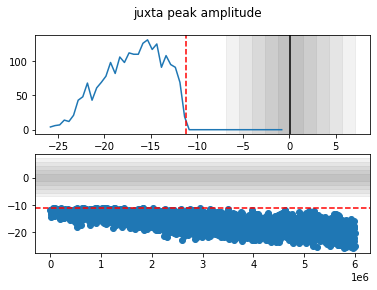

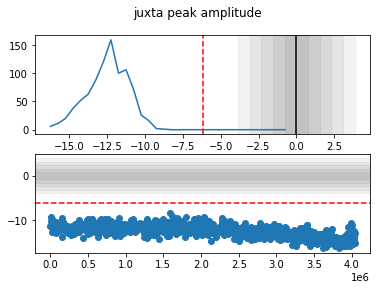

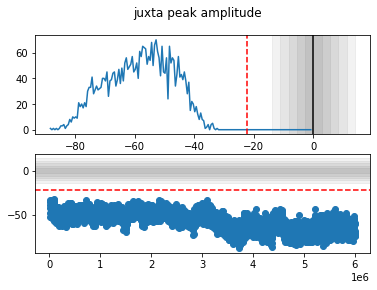

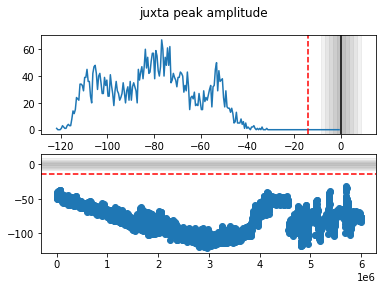

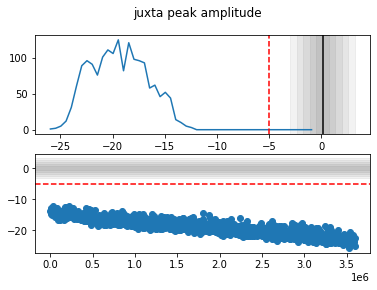

In [5]:
import os
recordings = {}
juxta = {}
peaks = {}
import numpy as np
import pylab as plt

for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'recordings' / folder / folder
    recording = si.read_mcsraw(str(file) + '.raw')
    recording.annotate(is_filtered=True)
    recording = recording.set_probegroup(probe)
    recordings[folder] = recording
    juxta[folder] = si.read_binary(str(file) + '.juxta.raw', sampling_frequency=20000, num_chan=1, dtype='float32')
    peaks[folder] = detect_peaks(juxta[folder], exclude_sweep_ms=2, detect_threshold=8)
    plot_juxta_amplitude(str(file) + '.juxta.raw', peaks[folder])

In [6]:
waveforms = {}
for folder in os.listdir(base_dir / 'recordings'):
    file = base_dir / 'waveforms' / folder
    times = peaks[folder]['sample_index']
    sorting = si.NumpySorting.from_times_labels(times, np.zeros(len(times), dtype=int), sampling_frequency=20000)
    waveforms[folder] = si.extract_waveforms(recordings[folder], sorting, ms_before=2, ms_after=2, mode='memory', n_jobs=-1, overwrite=True, chunk_memory="10M")

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/182 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/182 [00:00<?, ?it/s]

In [7]:
channel_positions = recordings['20160415_patch2'].get_channel_locations()
#real_positions = {'20160426_patch3' : channel_positions[226] + [0, -10],
#                  '20170726_patch1' : (0.9*channel_positions[30] + 0.1*channel_positions[3] + [5, 0]),
#                  '20170728_patch2' : channel_positions[118] + [0, 5],
#                  '20160426_patch2' : channel_positions[200] + [-15, -15], 
#                  '20160415_patch2' : (channel_positions[69] + channel_positions[33])/2.}

real_positions = {'20160426_patch3' : channel_positions[226] + [2, -5],
                  '20170726_patch1' : channel_positions[30] + [6,6],
                  '20170728_patch2' : channel_positions[118] + [-2,9],
                  '20160426_patch2' : channel_positions[200] + [-18, -12], 
                  '20160415_patch2' : channel_positions[69] +  [3,-15]}

In [8]:
%matplotlib inline

unit_positions = {}
spikes_positions = {}

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    unit_positions[folder] = {}
    spikes_positions[folder] = {}
    for method in ['center_of_mass', 'monopolar_triangulation', 'grid_convolution', 'peak_channel']:
        if method == 'center_of_mass':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'CoM ({feature})'
                params = {'feature' : feature}

                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                    method_kwargs=params, n_jobs=-1,
                                                                    spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                    chunk_memory="10M", outputs='by_unit')
        elif method == 'monopolar_triangulation':
            for feature in ['ptp', 'energy', 'peak_voltage']:
                title = f'Monopolar ({feature})'
                params = {'enforce_decrease': True, 'feature' : feature}
                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method, 
                                                            **params)
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                    method_kwargs=params, n_jobs=-1,
                                                                    spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                    chunk_memory="10M", outputs='by_unit')
        elif method == 'grid_convolution':
            for feature in ['gaussian_2d', 'exponential_3d']:
                title = f'Grid ({feature})'
                params = {'weight_method': {'mode' : feature}}
                from spikeinterface.core.node_pipeline import SpikeRetriever
                from spikeinterface.core.template_tools import get_template_extremum_channel
                extremum_channel_inds = get_template_extremum_channel(waveforms[folder], peak_sign="neg", outputs="index")
                spike_retriever = SpikeRetriever(
                            waveforms[folder].recording, waveforms[folder].sorting, extremum_channel_inds=extremum_channel_inds
                )
                #prototype = get_prototype_spike(waveforms[folder].recording, spike_retriever.peaks, 2, 2)
                #params['prototype'] = -prototype
                unit_positions[folder][title] = si.compute_unit_locations(waveforms[folder], method=method,
                                                                        **params)
        
                #prototype = get_prototype_spike(waveforms[folder].recording, spike_retriever.peaks, 0.5, 0.5)
                #params['prototype'] = prototype
                spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method,
                                                                                method_kwargs=params, n_jobs=-1,
                                                                                spike_retriver_kwargs={'channel_from_template' : False},
                                                                                chunk_memory="10M", outputs='by_unit')
        elif method == 'peak_channel':
            title = 'Peak Channel'
            params = {}
            from spikeinterface.core.template_tools import get_template_extremum_channel
            extremum_channel_inds = get_template_extremum_channel(waveforms[folder], peak_sign="neg", outputs="index")
            positions = waveforms[folder].recording.get_channel_locations()
            unit_positions[folder][title] = np.array([positions[i] for i in extremum_channel_inds.values()])
            spikes_positions[folder][title] = si.compute_spike_locations(waveforms[folder], method=method, 
                                                                method_kwargs=params, n_jobs=-1,
                                                                spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                chunk_memory="10M", outputs='by_unit')

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/204 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/204 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/303 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/182 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/182 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/182 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/182 [00:00<?, ?it/s]

In [11]:
colors = {}

import matplotlib as mpl

cmap = mpl.cm.tab20c
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for value, key in zip([0,0.05,0.1, 0.4,0.45,0.5, 0.6, 0.65, 0.9], spikes_positions['20160426_patch3'].keys()):    
    colors[key] = mpl.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(value)


/tmp/ipykernel_1528971/164532852.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])


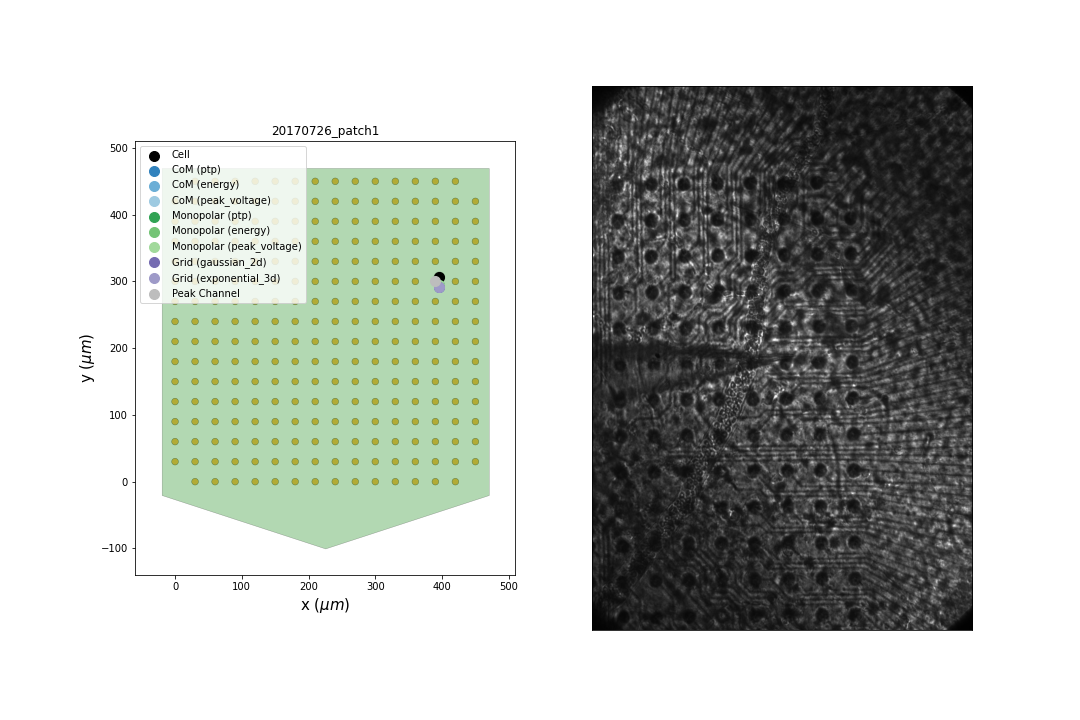

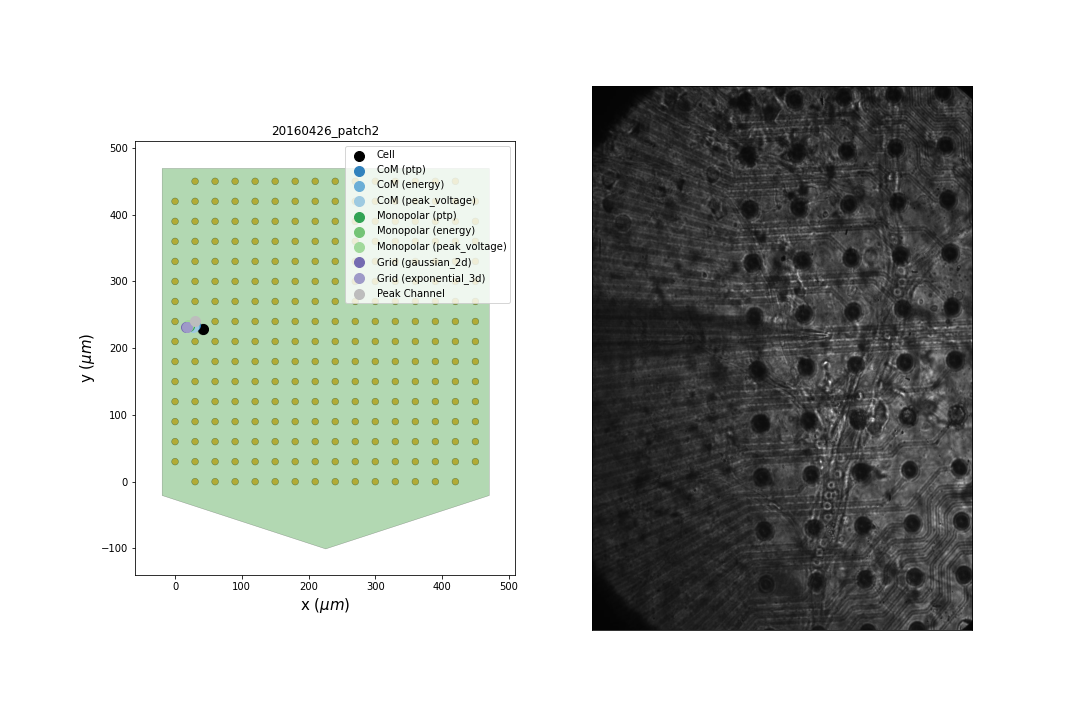

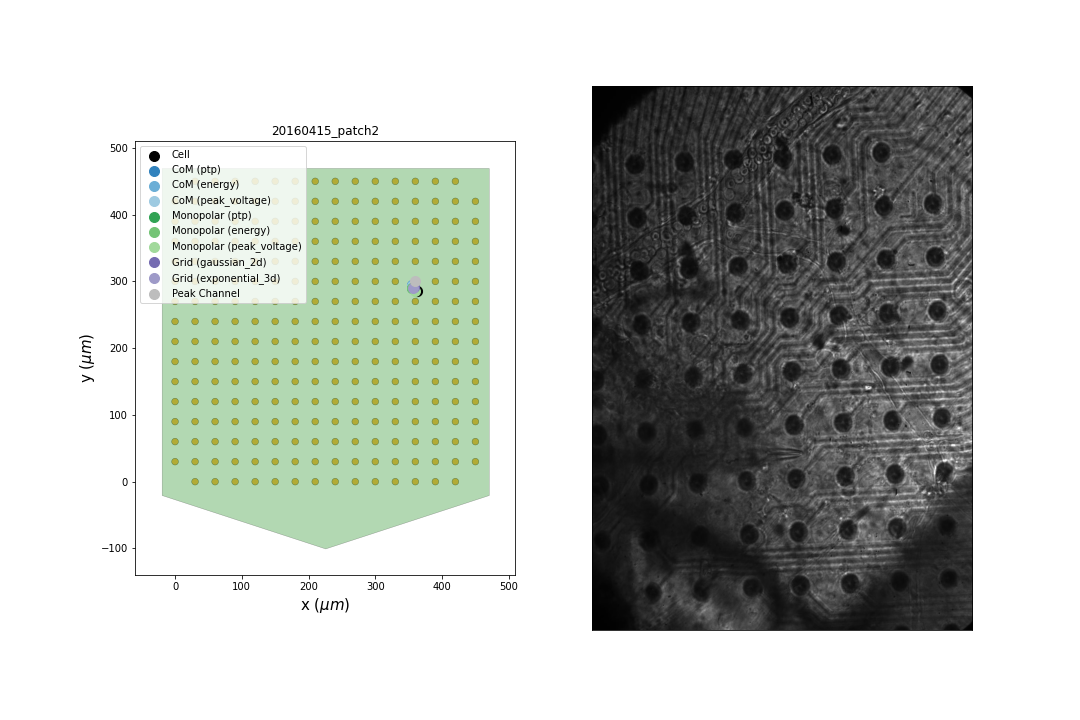

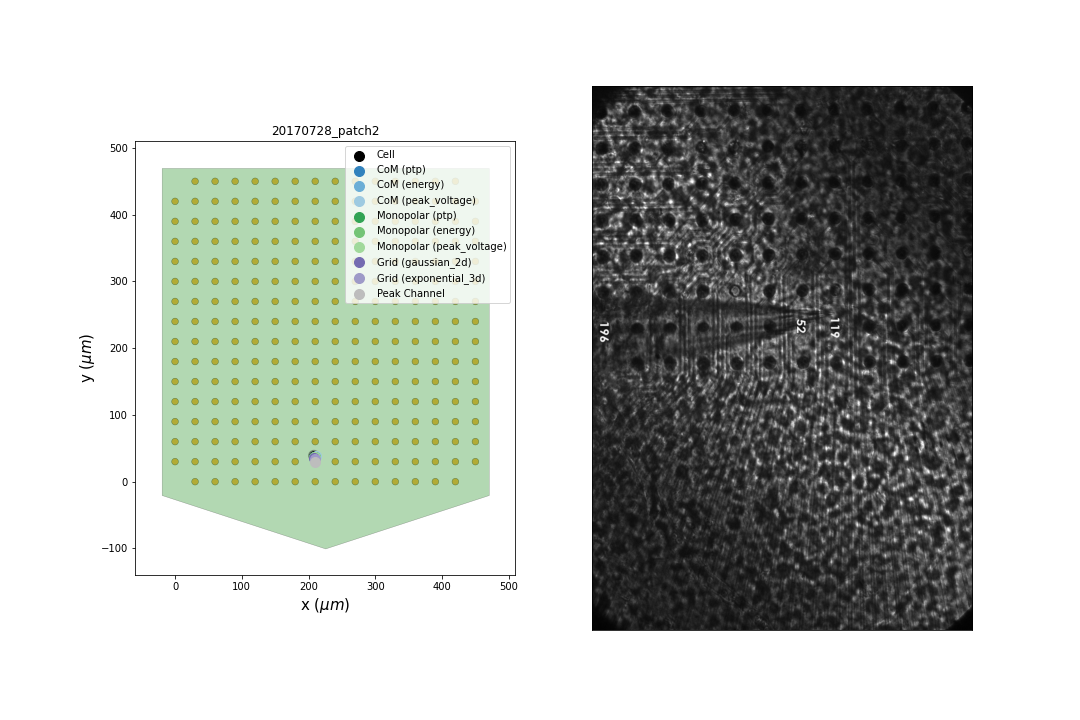

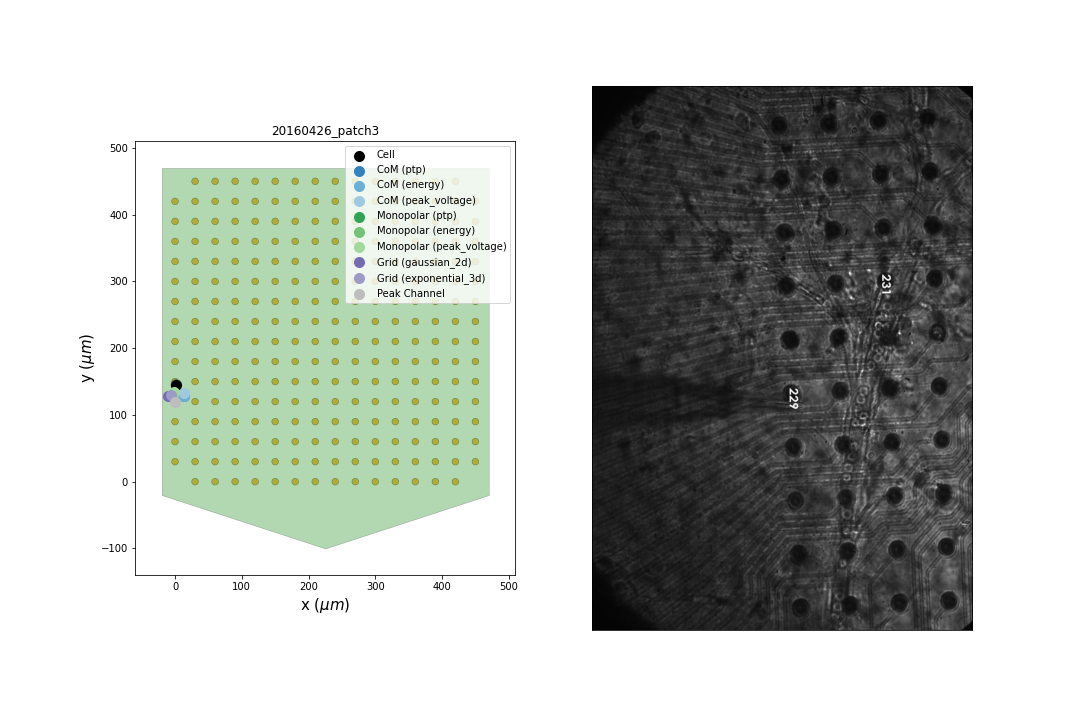

In [12]:
%matplotlib widget

import matplotlib.image as mpimg

for folder in  os.listdir(base_dir / 'recordings'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
    si.plot_probe_map(recording, ax=axes[0])
    
    #count = 0
    #for key, value in spikes_positions[folder].items():
    #    axes[0].scatter(value[0][0.0]['x'], value[0][0.0]['y'], alpha=0.01, c=f'C{count}')
    #    count += 1

    circle1 = plt.Circle((real_positions[folder][0], real_positions[folder][1]), 8, color='k', alpha=0.25)
    axes[0].add_patch(circle1)
    axes[0].scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell', c='k')

    
    for key, value in unit_positions[folder].items(): 
        axes[0].scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
    
    axes[0].legend()
    
    file = base_dir / 'recordings' / folder / folder
    img = mpimg.imread(f'{file}.jpg')
    imgplot = axes[1].imshow(img, aspect='auto', cmap='gray')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[0].set_title(folder)

In [13]:
def _simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [14]:
res_units = {}
res_spikes = {}
for folder in real_positions.keys():
    res_spikes[folder] = {}
    res_units[folder] = {}
    for key in unit_positions[folder].keys():
        res_units[folder][key] = np.linalg.norm(real_positions[folder] - unit_positions[folder][key][0, :2])
        
        data = spikes_positions[folder][key][0][0.0]
        errors = np.sqrt((data['x'] - real_positions[folder][0])**2 + (data['y'] - real_positions[folder][1])**2)
        res_spikes[folder][key] = list(errors)


In [15]:
res_units[folder]

{'CoM (ptp)': 11.802024662706545,
 'CoM (energy)': 12.370653509615222,
 'CoM (peak_voltage)': 11.946122159070613,
 'Monopolar (ptp)': 9.069454455963157,
 'Monopolar (energy)': 9.019919710730743,
 'Monopolar (peak_voltage)': 3.938423611758162,
 'Grid (gaussian_2d)': 9.226673962595983,
 'Grid (exponential_3d)': 8.227446275898174,
 'Peak Channel': 15.297058540778355}

In [32]:
colors = {}

import matplotlib as mpl

cmap = mpl.cm.tab20c
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for value, key in zip([0,0.05,0.1, 0.4,0.45,0.5, 0.6, 0.65, 0.9], spikes_positions['20160426_patch3'].keys()):    
    colors[key] = mpl.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(value)
print(colors)

{'CoM (ptp)': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0), 'CoM (energy)': (0.4196078431372549, 0.6823529411764706, 0.8392156862745098, 1.0), 'CoM (peak_voltage)': (0.6196078431372549, 0.792156862745098, 0.8823529411764706, 1.0), 'Monopolar (ptp)': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235, 1.0), 'Monopolar (energy)': (0.4549019607843137, 0.7686274509803922, 0.4627450980392157, 1.0), 'Monopolar (peak_voltage)': (0.6313725490196078, 0.8509803921568627, 0.6078431372549019, 1.0), 'Grid (gaussian_2d)': (0.4588235294117647, 0.4196078431372549, 0.6941176470588235, 1.0), 'Grid (exponential_3d)': (0.6196078431372549, 0.6039215686274509, 0.7843137254901961, 1.0), 'Peak Channel': (0.7411764705882353, 0.7411764705882353, 0.7411764705882353, 1.0)}


In [33]:
distances_to_center = {}
variances = []
local_variances = []
means = []
outliers = []
for folder in real_positions.keys():
    distances_to_center[folder] = np.linalg.norm(real_positions[folder]-225)
    all_estimates = []
    for key in unit_positions[folder].keys():
        all_estimates += [unit_positions[folder][key][0, :2]]
    all_estimates = np.array(all_estimates)
    #print(all_estimates)
    #print(centroid)
    errors = np.linalg.norm(real_positions[folder] - all_estimates, axis=1)

    centroid = np.mean(all_estimates, 0)
    local_errors = np.linalg.norm(centroid - all_estimates, axis=1)
    print(local_errors)
    variances += [np.std(local_errors)]
    local_variances += [np.std(local_errors)]
    outliers  += [(local_errors - np.mean(local_errors)) / np.std(local_errors) > 1]
    means += [np.mean(errors)]
variances = np.array(variances)
local_variances = np.array(local_variances)
means = np.array(means)
outliers = np.array(outliers)

[11.27010492 11.22072382 12.48783097  5.15129854  4.44192805  6.27539645
 12.24514373  8.00199089  9.73797852]
[1.12149288 2.2448779  1.39908703 1.11992867 1.03495857 0.96971029
 2.21614067 1.83470072 7.54831867]
[1.67818267 1.62031408 2.8528665  0.87783042 1.25713504 1.1511945
 0.83386108 1.27597102 5.98025892]
[7.083387   5.53955942 3.51314956 1.86453273 3.24362148 4.46899146
 7.52374703 6.45862412 9.12989547]
[2.18860192 2.80994588 2.32462977 2.46797145 2.65495573 7.43545067
 0.95255011 2.43323837 8.57420272]


In [27]:
snrs = []
for folder in real_positions.keys():
    snrs += [si.compute_snrs(waveforms[folder])[0.0]]

[236.91559679 189.21416437 186.77526603 183.02458851 150.47923445] ['20160415_patch2' '20160426_patch2' '20170728_patch2' '20170726_patch1'
 '20160426_patch3']


Text(0.5, 0, 'snr')

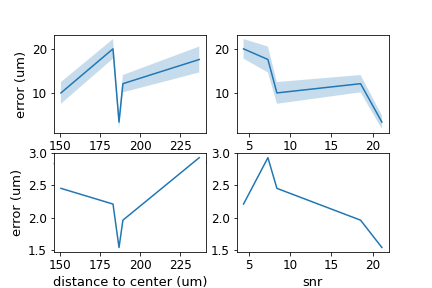

In [28]:
plt.close()
fig = plt.figure()
axes = fig.subplots(2, 2)
data = np.array(list(distances_to_center.values()))
keys = np.array(list(distances_to_center.keys()))
idx = np.argsort(data)
print(data, keys[idx])

axes[0,0].plot(data[idx], means[idx])
axes[0,0].fill_between(data[idx], means[idx]-variances[idx], means[idx]+variances[idx], alpha=0.25)
axes[0,0].set_xlabel('distance to center (um)')
axes[0,0].set_ylabel('error (um)')

axes[1,0].plot(data[idx], local_variances[idx])
axes[1,0].set_xlabel('distance to center (um)')
axes[1,0].set_ylabel('error (um)')
data = np.array(snrs)
idx = np.argsort(data)

data = np.array(snrs)
idx = np.argsort(data)
axes[0,1].plot(data[idx], means[idx])
axes[0,1].fill_between(data[idx], means[idx]-variances[idx], means[idx]+variances[idx], alpha=0.25)
axes[0,1].set_xlabel('snr')

axes[1,1].plot(data[idx], local_variances[idx])
axes[1,1].set_xlabel('snr')

/tmp/ipykernel_1528971/2938173674.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
/tmp/ipykernel_1528971/2938173674.py:81: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
/tmp/ipykernel_1528971/2938173674.py:99: UserWarning: *c* argument looks like a single numeric RGB or RGBA

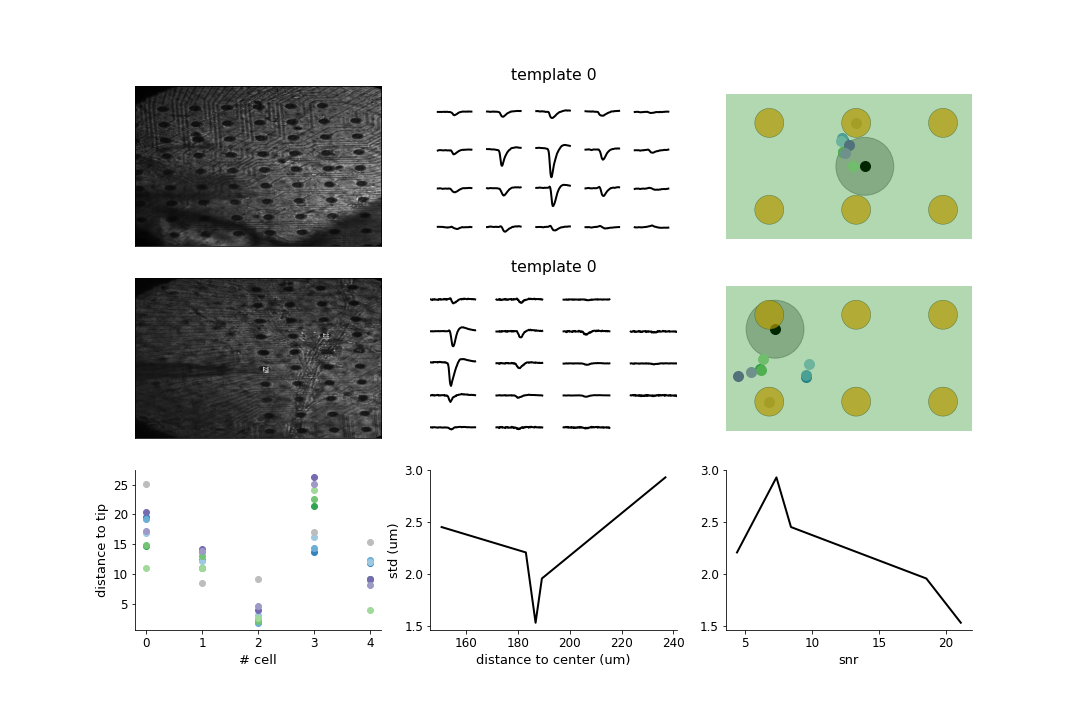

In [49]:
fig = plt.figure(figsize=(15, 10))

gs = fig.add_gridspec(3, 3)

plt.rc('font', size=13)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

folder = '20160415_patch2'
file = base_dir / 'recordings' / folder / folder
img = mpimg.imread(f'{file}.jpg')

ax = fig.add_subplot(gs[0, 0])

imgplot = ax.imshow(img, aspect='auto', cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[0, 1])
si.plot_unit_templates(waveforms[folder], ax=ax, same_axis=True, unit_colors={0 : 'k'}, plot_legend=False, shade_templates=False)
ax.set_xlim(285, 435)
ax.set_ylim(225, 350)
_simpleaxis(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
_simpleaxis(ax)

ax = fig.add_subplot(gs[0, 2])
ax.scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell', color='k')
circle1 = plt.Circle((real_positions[folder][0], real_positions[folder][1]), 10, color='k', alpha=0.25)
ax.add_patch(circle1)

for key, value in unit_positions[folder].items(): 
    ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
si.plot_probe_map(recording, ax=ax)

_simpleaxis(ax)
ax.set_xlim(315, 400)
ax.set_ylim(260, 310)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


folder = '20160426_patch3'
file = base_dir / 'recordings' / folder / folder
img = mpimg.imread(f'{file}.jpg')

ax = fig.add_subplot(gs[1, 0])

imgplot = ax.imshow(img, aspect='auto', cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 1])
si.plot_unit_templates(waveforms[folder], ax=ax, same_axis=True, unit_colors={0 : 'k'}, plot_legend=False, shade_templates=False)
ax.set_xlim(-10, 100)
ax.set_ylim(50, 200)
_simpleaxis(ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
_simpleaxis(ax)

ax = fig.add_subplot(gs[1, 2])
ax.scatter([real_positions[folder][0]], [real_positions[folder][1]], s=100, label='Cell', color='k')
circle1 = plt.Circle((real_positions[folder][0], real_positions[folder][1]), 10, color='k', alpha=0.25)
ax.add_patch(circle1)

for key, value in unit_positions[folder].items(): 
    ax.scatter([value[0][0]], [value[0][1]], s=100, label=key, c=colors[key])
si.plot_probe_map(recording, ax=ax)

_simpleaxis(ax)
ax.set_xlim(-15, 70)
ax.set_ylim(110, 160)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



ax = fig.add_subplot(gs[2, 0])
for count, (k, v) in enumerate(res_units.items()):
    for method, vv in v.items():
        ax.scatter([count], [vv], c=colors[method])
_simpleaxis(ax)
ax.set_ylabel('distance to tip')
ax.set_xlabel('# cell')

ax = fig.add_subplot(gs[2, 1])
data = np.array(list(distances_to_center.values()))
keys = np.array(list(distances_to_center.keys()))
idx = np.argsort(data)
ax.plot(data[idx], local_variances[idx], c='k', lw=2)
ax.set_xlabel('distance to center (um)')
ax.set_ylabel('std (um)')
data = np.array(snrs)
idx = np.argsort(data)
_simpleaxis(ax)

ax = fig.add_subplot(gs[2, 2])
ax.plot(data[idx], local_variances[idx], c='k', lw=2)
ax.set_xlabel('snr')
_simpleaxis(ax)

# ax = fig.add_subplot(gs[2, 2])
# ax.bar(np.arange(9), outliers.sum(0), facecolor='k')
# ax.set_ylabel('outliers')
# ax.set_xticks(np.arange(9), spikes_positions[folder].keys(), rotation=45)
# _simpleaxis(ax)

# count = 0

# all_units = {}
# for folder, data in res_units.items():
#     for method, value in data.items():
#         if method not in all_units:
#             all_units[method] = [value]
#         else:
#             all_units[method] += [value]

# ax = fig.add_subplot(gs[2:4, 0])
# for key, value in all_units.items():
#     ax.bar([count], np.array(value).mean(), yerr=np.array(value).std(), facecolor=colors[key])
#     count += 1
# ax.set_ylabel('error (um)')
# ax.set_title('Averaged template')
# ax.set_ylim(0, 30)
# #axes[1, 0].set_yscale('log')
# ax.plot([-0.5, len(all_units.keys())], [10, 10], 'k--')
    
# _simpleaxis(ax)



# ax = fig.add_subplot(gs[2:4, 1])
# #axes[1, 0].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)


# all_spikes = {}
# for folder, data in res_spikes.items():
#     for method, value in data.items():
#         if method not in all_spikes:
#             all_spikes[method] = value
#         else:
#             all_spikes[method] += value

# count = 0
# for key, value in all_spikes.items():
#     ax.bar([count], np.array(value).mean(), yerr=np.array(value).std(), facecolor=colors[key])
#     count += 1

# #axes[1, 1].set_yscale('log')
# _simpleaxis(ax)
# #axes[1, 1].set_xticks(np.arange(len(res_unit.keys())), res_unit.keys(), rotation=45)
# ax.set_ylabel('error (um)')
# ax.set_title('Single spikes')
# ax.set_ylim(0, 30)
# ax.set_xticks([], [])
# ax.plot([-0.5, len(all_units.keys())], [10, 10], 'k--')

# res = []
# for folder in real_positions.keys():
#     res += [si.compute_snrs(waveforms[folder])[0.0]]

# idx = np.argsort(res)
# res = np.array(res)



# all_means = {}
# all_stds = {}

# for key in res_spikes.keys():
#     for method in res_spikes[key].keys():
#         if method in all_means:
#             all_means[method] += [np.mean(res_spikes[key][method])]
#             all_stds[method] += [np.std(res_spikes[key][method])]
#         else:
#             all_means[method] = [np.mean(res_spikes[key][method])]
#             all_stds[method] = [np.std(res_spikes[key][method])]

            

# ax_1 = fig.add_subplot(gs[2, 2])
# ax_2 = fig.add_subplot(gs[3, 2])
# for key in all_means.keys():
#     all_means[key] = np.array(all_means[key])
#     all_stds[key] = np.array(all_stds[key])
#     ax_1.plot(res[idx], all_means[key][idx], label=key, c=colors[key]) 
#     ax_2.plot(res[idx], all_stds[key][idx], label=key, c=colors[key]) 
# _simpleaxis(ax_1)
# _simpleaxis(ax_2)

# #ax_1.set_xlabel('snr (dB)')
# ax_1.set_ylabel('error (um)')

# ax_2.set_xlabel('snr (dB)')
# ax_2.set_ylabel('std error (um)')

# #ax.legend()
plt.savefig('gt.pdf')
